<a href="https://colab.research.google.com/github/tszabad/deep_learning/blob/main/Copy_of_Day03_Task_Sentiment_classification_handout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! python -m spacy download en
! pip install wordcloud
! wget "https://drive.google.com/uc?export=download&id=19NUVV29Pq-j2WrNBYf6WRD8or7SOUHp2" -O sentiment.tsv

     |████████████████████████████████| 12.0 MB 8.2 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
--2021-08-06 15:18:49--  https://drive.google.com/uc?export=download&id=19NUVV29Pq-j2WrNBYf6WRD8or7SOUHp2
Resolving drive.google.com (drive.google.com)... 74.125.195.139, 74.125.195.113, 74.125.195.101, ...
Connecting to drive.google.com (drive.google.com)|74.125.195.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-3o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/qoc9jeo11l4grure6252er5iqo2si4ik/1628263125000/10227734428265054086/*/19NUVV29Pq-j2WrNBYf6WRD8or7SOUHp2?e=download [following]
--2021-08-06 15:18:50--  https://doc-0k-3o-docs.googleusercontent.com/docs/secure

# Task: sentiment classification

The task is to classify one-sentence long movie reviews/opinions according to the sentiment they express. There are only two categories: positive and negative sentiment.


> "Data source: [UMICH SI650 - Sentiment Classification](https://www.kaggle.com/c/si650winter11/data)

> Training data: 7086 lines. 
  
> Format: 1|0 (tab) sentence

> Test data: 33052 lines, each contains one sentence. 

> The data was originally collected from opinmind.com (which is no longer active)."

The data is in the file "sentiment.tsv".

# Loading the data

In [ ]:
import pandas as pd

df = pd.read_csv('sentiment.tsv', sep='\t', 
                 quoting=3, # Quotes are _never_ field separators
                 header=None)

df.head()

,0,1
0,1,The Da Vinci Code book is just awesome.
1,1,this was the first clive cussler i've ever rea...
2,1,i liked the Da Vinci Code a lot.
3,1,i liked the Da Vinci Code a lot.
4,1,I liked the Da Vinci Code but it ultimatly did...


In [ ]:
df = df[[1,0]] # rearrange columns

df.rename(columns={1:"text", 0:"sentiment"}, inplace=True) # rename columns

df.head()

,text,sentiment
0,The Da Vinci Code book is just awesome.,1
1,this was the first clive cussler i've ever rea...,1
2,i liked the Da Vinci Code a lot.,1
3,i liked the Da Vinci Code a lot.,1
4,I liked the Da Vinci Code but it ultimatly did...,1


# Splitting into train, validation and test

Before doing anything else (!) we divide our data into train, validation and test parts,

In [ ]:
# Import the necessary function from Scikit
from sklearn.model_selection import train_test_split

# Please observe, that we can only do a split into two
# hence our best option is to call the function twice in a chain
# Don't forget to fix the random seed also, eg to 13, since that is a lucky number! :-)
df_train, df_test_valid = train_test_split(df, test_size=0.2, random_state=42)

df_test, df_valid = train_test_split(df_test_valid , test_size=0.5, random_state=42)

assert len(df_train)==5668 and len(df_valid)==709 and len(df_test)==709
print(len(df_train), len(df_valid), len(df_test))

5668 709 709


# Inspecting the data

In [ ]:
df_train.describe()

,sentiment
count,5668.000000
mean,0.565102
std,0.495787
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


We can examine the lengths of sentences as well.

In [ ]:
n_chars = df_train.text.apply(lambda x: len(x))

n_chars.describe()

count    5668.000000
mean       59.759174
std        37.667999
min        19.000000
25%        32.000000
50%        47.000000
75%        77.000000
max       228.000000
Name: text, dtype: float64

The first sentence with the maximal length:

In [ ]:
long_sentence = df_train.loc[n_chars.idxmax(), "text"]
long_sentence

'We had some awesome times at school in between classes, from settin things on fire to doing Mission Impossible things in the halls, to partyin weekends and clubbin to lunch in between classes causing disruption wherever we went.'

# Extra task: Let's do a word cloud!

Let us visualize together and separately (by category) the sentences!

Tool: https://github.com/amueller/word_cloud


Good example: https://github.com/amueller/word_cloud/blob/master/examples/simple.py



In [ ]:
# Helper function for displaying a word cloud
# Input: one _UNIFIED_, space separated string!
# Protip: https://www.tutorialspoint.com/python/string_join.htm
def do_wordcloud(text):
    from wordcloud import WordCloud
    
    # Generate a word cloud image
    wordcloud = WordCloud().generate(text)

    # Display the generated image:
    # the matplotlib way:
    import matplotlib.pyplot as plt

    # lower max_font_size
    wordcloud = WordCloud(max_font_size=40).generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()


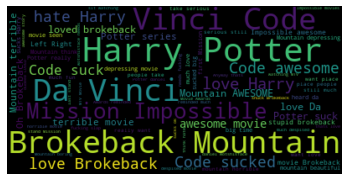

In [ ]:
### TASK !!! ####
#Put here the world cloud!
from functools import reduce

text = df_train["text"].values.tolist()

text = str(reduce(lambda a, b: a + b + " ", text))
do_wordcloud(text)

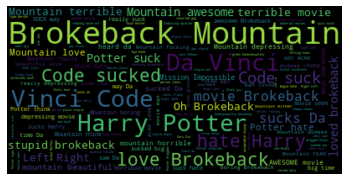

In [ ]:
### TASK !!! ####
# Here only the cloud for sentences with negative sentiment!
# Help: the shape of the DataFrame with only the negative sentences is: (2975, 2)
# Source: https://pandas.pydata.org/pandas-docs/stable/indexing.html

text2 = df.loc[2975:, ["text"]].values
text2 = str(reduce(lambda a, b: a + b + " ", text2))
do_wordcloud(text2)


# Bag of words (BoW) representation of the texts

We will represent each text as a (sparse) vector of lemma (word root) counts for frequent lemmas in the training data. 

For tokenization and lemmatization we use [spaCy](https://spacy.io/), an open source Python NLP library, which can produce a list of unique lemma ids from the text.

In [ ]:
import spacy

nlp = spacy.load("en", disable=["parser", "ner"]) 
# We only need the tokenizer, all higher functions are now unnecessary.

spaCy can produce spaCy Doc objects from texts that contain their linguistic analysis, among others lemmas and their unique spaCy string ids.

In [ ]:
doc = nlp(long_sentence)
type(doc)

spacy.tokens.doc.Doc

In [ ]:
print([token.lemma_ for token in doc ]) # Lemmas

['-PRON-', 'have', 'some', 'awesome', 'time', 'at', 'school', 'in', 'between', 'class', ',', 'from', 'settin', 'thing', 'on', 'fire', 'to', 'do', 'Mission', 'impossible', 'thing', 'in', 'the', 'hall', ',', 'to', 'partyin', 'weekend', 'and', 'clubbin', 'to', 'lunch', 'in', 'between', 'class', 'cause', 'disruption', 'wherever', '-PRON-', 'go', '.']


In [ ]:
print([token.lemma for token in doc]) # Connected unique ID-s

[561228191312463089, 14692702688101715474, 7000492816108906599, 3240785716591152042, 8885804376230376864, 11667289587015813222, 13293160603192985325, 3002984154512732771, 7508752285157982505, 12859657019542931961, 2593208677638477497, 7831658034963690409, 7103864560959692266, 2473243759842082748, 5640369432778651323, 136626128350750948, 3791531372978436496, 2158845516055552166, 5682848027012789304, 3697056306505531193, 2473243759842082748, 3002984154512732771, 7425985699627899538, 6811010198686381007, 2593208677638477497, 3791531372978436496, 8889062159812809249, 6105388159866233819, 2283656566040971221, 10055968936965974391, 3791531372978436496, 7857862308360435530, 3002984154512732771, 7508752285157982505, 12859657019542931961, 2309615733100196421, 1811315605088533490, 1241748081402320109, 561228191312463089, 8004577259940138793, 12646065887601541794]


Now we have to convert these lists into BoW vectors. We could "roll our own", but, fortunately, scikit-learn has a feature extractor doing exactly that, the [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer) so, for the sake of simplicity, we will use that along with spaCy.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(analyzer=lambda s: [token.lemma for token in nlp(s)], #spaCy for analysis
                     min_df= 0.001) # We ignore the lemmas with low document frequency
cv

CountVectorizer(analyzer=<function <lambda> at 0x7fbdc45879e0>, binary=False,
                decode_error='strict', dtype=<class 'numpy.int64'>,
                encoding='utf-8', input='content', lowercase=True, max_df=1.0,
                max_features=None, min_df=0.001, ngram_range=(1, 1),
                preprocessor=None, stop_words=None, strip_accents=None,
                token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None,
                vocabulary=None)

In [ ]:
sents = ["I hate this movie.", "The movie is the worst I've seen."]
bows = cv.fit_transform(sents).toarray() 
# A CountVectorizer produces a sparse matrix, we convert to ndarray
bows

array([[1, 1, 0, 1, 0, 0, 0, 1, 0, 1],
       [1, 0, 2, 0, 1, 1, 1, 1, 1, 1]])

Using the CountVectorizer we convert the text columns of our train, validation and  test data into three sparse matrices.

In [ ]:
bows_train = cv.fit_transform(df_train.text)
bows_train.sort_indices() # comes from TF2.0 sparse implementation, obscure requirement
bow_length = bows_train.shape[1]
print("BoW length:", bow_length)
bows_train

BoW length: 373


<5668x373 sparse matrix of type '<class 'numpy.int64'>'
	with 62980 stored elements in Compressed Sparse Row format>

In [ ]:
bows_valid = cv.transform(df_valid.text)
bows_valid.sort_indices() # comes from TF2.0 sparse implementation, obscure requirement
bows_test = cv.transform(df_test.text)
bows_test.sort_indices() # comes from TF2.0 sparse implementation, obscure requirement

# Task: The model

We build a feed-forward neural network in Keras for our binary classification task, which will be trained with cross-entropy loss and minibatch SGD.

In [ ]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD


# USE KERAS FUNKTIONAl API!

 


# Parameters
############

hidden_size = 100
length = (373)

number_of_classes = 2

# Model
#######
# Define (instantiate) the input layer!
# Give the shape parameter the length of a BoW vector as length
# WARNING: shape only accepts a tuple, even is one dimensional!
inputs = Input(shape=(length))

# Hidden layer
##############
# Define a fully connected hidden layer that can be modified by the parameters above!
# Use the ReLU activation function
# Give the inputs to the hidden layer
# Please be aware, that in Keras Functional, the parameters defining the layer are 
# "instantiation" parameters, but the input of the layer is already a "call" parameter!
# (The magic lies in the brackets... ;-)

hidden_output = Dense(hidden_size, activation='relu')(inputs)



# Softmax 
#########
# Define the output softmax
# (Which is a fully connected layer with activation accordingly...)
# Please remember, we have exactly two classes! 
# (We choose to use this generalized, Softmax approach...)
# We feed the layer with the output of the hidden one.


predictions = Dense(number_of_classes, activation='softmax')(hidden_output)

# Whole model
##############
# Nothing more is left, than to instantiate the model
# Please ensure input and output is right!

model = model = Model(inputs=inputs, outputs=predictions)


# Optimization
##############
# For now, we stick to this.
optimizer = SGD(lr=0.1)
 

# Compilation and teaching
##########################

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy', # use this cross entropy variant
                                                      # since the input is not one-hot encoded
              metrics=['accuracy']) #We measure and print accuracy during training

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


# Training

In [ ]:
model.fit(x=bows_train, 
          y=df_train.sentiment.values,
          validation_data=(bows_valid, df_valid.sentiment.values),
          epochs=10,
          batch_size=200)

# Please don't just run, understand!

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/dense_4/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model/dense_4/embedding_lookup_sparse/Reshape:0", shape=(None, 100), dtype=float32), dense_shape=Tensor("gradient_tape/model/dense_4/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


29/29 [==============================] - 3s 9ms/step - loss: 0.5345 - accuracy: 0.8020 - val_loss: 0.3966 - val_accuracy: 0.9196
Epoch 2/10
29/29 [==============================] - 0s 4ms/step - loss: 0.3173 - accuracy: 0.9480 - val_loss: 0.2406 - val_accuracy: 0.9676
Epoch 3/10
29/29 [==============================] - 0s 4ms/step - loss: 0.1989 - accuracy: 0.9714 - val_loss: 0.1634 - val_accuracy: 0.9647
Epoch 4/10
29/29 [==============================] - 0s 4ms/step - loss: 0.1395 - accuracy: 0.9746 - val_loss: 0.1249 - val_accuracy: 0.9690
Epoch 5/10
29/29 [==============================] - 0s 4ms/step - loss: 0.1073 - accuracy: 0.9772 - val_loss: 0.1018 - val_accuracy: 0.9704
Epoch 6/10
29/29 [==============================] - 0s 4ms/step - loss: 0.0875 - accuracy: 0.9787 - val_loss: 0.0873 - val_accuracy: 0.9732
Epoch 7/10
29/29 [==============================] - 0s 4ms/step - loss: 0.0747 - accuracy: 0.9795 - val_loss: 0.0771 - val_accuracy: 0.9746
Epoch 8/10
29/29 [=============

# Prediction

In [ ]:
print("=== INTERACTIVE DEMO ===")
while True:
    s = input("Enter a short text to evaluate or press return to quit: ")
    if s == "":
        break
    else:
        bow = cv.transform([s])
        prob_pred = model.predict(bow[0])
        print(f"Positive vs negative sentiment probability: {prob_pred[0,1]} vs {prob_pred[0,0]}")

=== INTERACTIVE DEMO ===
Enter a short text to evaluate or press return to quit: it was a terrible movie
Positive vs negative sentiment probability: 0.29899707436561584 vs 0.7010029554367065
Enter a short text to evaluate or press return to quit: we laughed a lot
Positive vs negative sentiment probability: 0.6251547932624817 vs 0.3748452067375183
